 # Self-SuperVised Learning with SimCLR
 #### This notebook aims to demonstrate the ****most basic**** use case of self-supervised learning with SimCLR.
 ## Overview
#### 1.  **Implementing SimCLR. Here SimCLR is a simple framework for contrastive learning of visual representations.**
 
#### 2.  **Next We train a Linear Classification model build over the contrastive model on the same training dataset.**

# Importing Libraries

In [115]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transform
import torchvision.models as models
import numpy as np
import os
import glob
import time
from skimage import io
from tqdm import tqdm
import matplotlib.pyplot as plt

In [116]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Creating DataLoader and CustoomDataset

In [117]:
image_transform = transform.Compose([
    transform.ToTensor(),
    transform.RandomResizedCrop(size = [224, 224]),
    transform.RandomHorizontalFlip(p=0.5),
    transform.RandomApply([transform.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
    transform.RandomGrayscale(p=0.2),
    transform.RandomApply([transform.GaussianBlur(kernel_size=[21,21])], p=0.5)  # kernel_size is 10 percent of the output shape 224.
])

In [132]:
class CustomDataset(Dataset):

    def __init__(self, list_path):

        self.list_path = list_path

    def __len__(self):
        return len(self.list_path)

    def __getitem__(self, idx):
            
        img_path = self.list_path[idx]
        image = io.imread(img_path)
        image = [image_transform(image) for i in range(2)]
        
        return image

In [133]:
train_data = CustomDataset(list_path=glob.glob("/kaggle/input/flowers-recognition/flowers/*/*.jpg"))

In [134]:
train_loader = DataLoader(train_data ,  batch_size = 128 ,  shuffle = True )

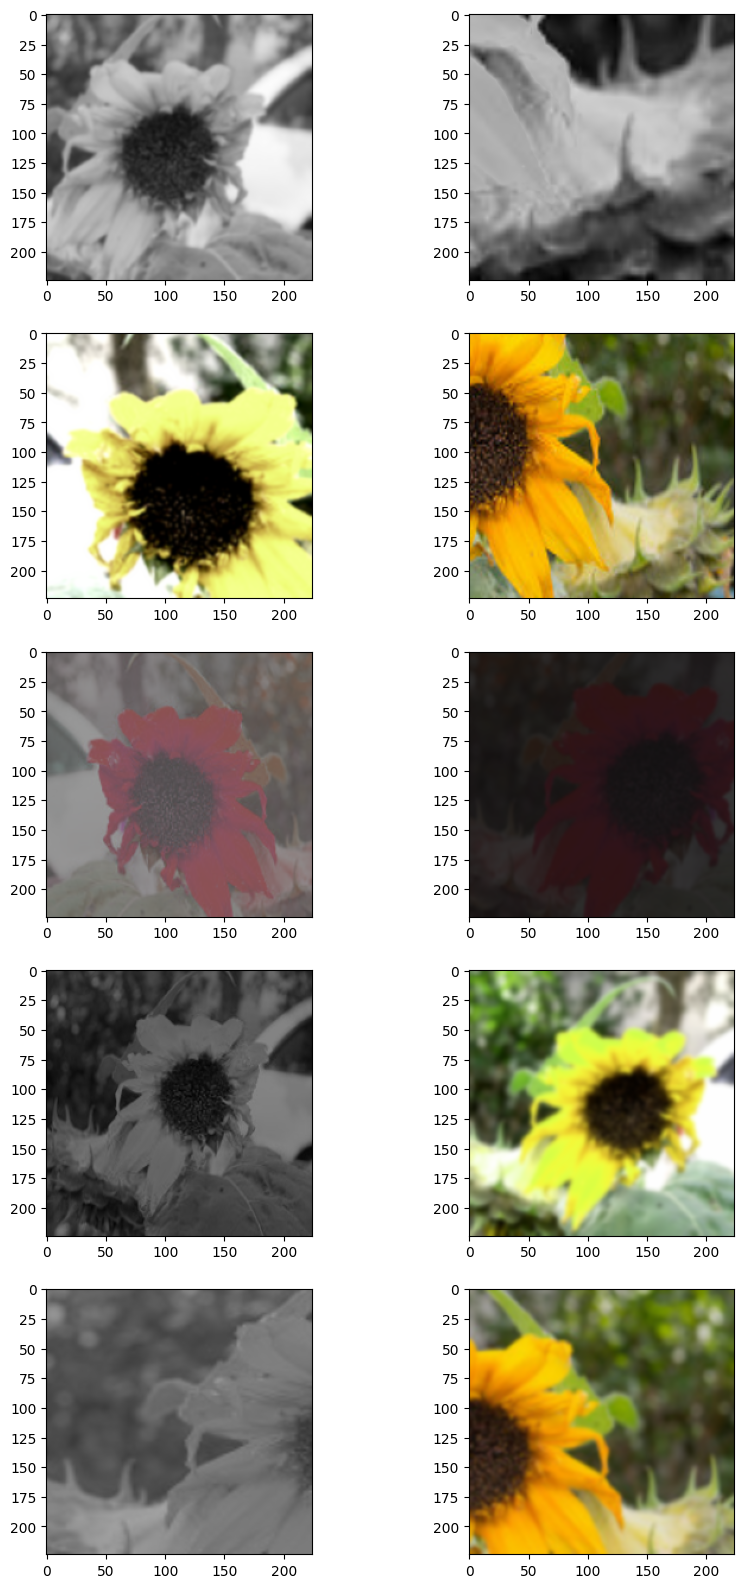

In [135]:
plt.figure(figsize=(10,20))
def plot_images(flowers, index):
    for i in range(1,6):
        images = flowers[index]
        view1, view2 = images
        plt.subplot(5,2,2*i-1)
        plt.imshow(view1.permute(1,2,0))
        plt.subplot(5,2,2*i)
        plt.imshow(view2.permute(1,2,0))

plot_images(train_data, 2000)

# Implementing SimCLR

In [137]:
class SimCLR(nn.Module):
    def __init__(self):
        super(SimCLR, self).__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.fc = nn.Sequential(
                                      nn.Linear(512, 256),
                                      nn.ReLU(),
                                      nn.Linear(256 , 256)
                                            )      
    def forward(self, x):
        x = self.model(x)
        return x

In [138]:
model_sim = SimCLR().to(device)

In [139]:
model_sim

SimCLR(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

## Creating The SimCLR loss. 
##### The contrastive loss function used here is take from an implementation of the The NTxent Loss inspired from the original code of the SimCLR from its github code.

In [152]:
LABELS = torch.cat([torch.arange(128) for i in range(2)], dim=0)
LABELS = (LABELS.unsqueeze(0) == LABELS.unsqueeze(1)).float() # Creates a one-hot with broadcasting
LABELS = LABELS.to(device) #128,128
sim = nn.CosineSimilarity(dim=2)
def cont_loss(features, temp):
    """
    The NTxent Loss.
    
    Args:
        z1: The projection of the first branch
        z2: The projeciton of the second branch
    
    Returns:
        the NTxent loss
    """
    
    z_i , z_j = features
    z = torch.cat((z_i, z_j), dim=0)
    
    similarity_matrix =  sim(z.unsqueeze(1), z.unsqueeze(0)) # 128, 128
    # discard the main diagonal from both: labels and similarities matrix
    mask = torch.eye(LABELS.shape[0], dtype=torch.bool).to(device)
    # ~mask is the negative of the mask
    # the view is required to bring the matrix back to shape
    labels = LABELS[~mask].view(LABELS.shape[0], -1) # 128, 127
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1) # 128, 127

    # select and combine multiple positives
    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1) # 128, 1

    # select only the negatives
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1) # 128, 126

    logits = torch.cat([positives, negatives], dim=1) # 128, 127
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(device)
    logits = logits / temp
    
    return logits, labels

In [153]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_sim.parameters())

In [156]:
EPOCHS = 5
for epoch in range(EPOCHS):
    print("Epoch: {}/{}".format(epoch+1,EPOCHS))
    loss = 0.0
    for i, image in tqdm(enumerate(train_loader) , total=len(train_loader)):
        image1 = image[0]
        image2 = image[1]
        if(i != 33):  # skipping the last batch
            
            projections = [model_sim(image1.to(device)), model_sim(image2.to(device))]
            logits, labels = cont_loss(projections, 2)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            loss += loss.item()  
        
    print(f'Loss: {loss/(i+1):.4f} ')


Epoch: 1/5


100%|██████████| 34/34 [03:17<00:00,  5.82s/it]


Loss: 0.3210 
Epoch: 2/5


100%|██████████| 34/34 [03:17<00:00,  5.81s/it]


Loss: 0.3163 
Epoch: 3/5


100%|██████████| 34/34 [03:23<00:00,  6.00s/it]


Loss: 0.3181 
Epoch: 4/5


100%|██████████| 34/34 [03:17<00:00,  5.82s/it]


Loss: 0.3134 
Epoch: 5/5


100%|██████████| 34/34 [03:20<00:00,  5.90s/it]

Loss: 0.3163 


# Training a Linear classifier on the same dataset

In [157]:
dataset = ImageFolder(
    root="/kaggle/input/flowers-recognition/flowers/",
    transform=image_transform
)

In [158]:
train_loader = DataLoader(dataset,  batch_size = 128 ,  shuffle = True )

In [159]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

class LinearEvaluation(nn.Module):
    def __init__(self, model, nu_classes):
        super().__init__()
        self.simclr = model
        for param in self.simclr.parameters():
            param.requires_grad = False
        self.linear = nn.Sequential(nn.Linear(256, 5),
                                   )
    def forward(self, x):
        encoding = self.simclr(x)
        pred = self.linear(encoding) 
        return pred

In [160]:
model = LinearEvaluation(model_sim, 5).to(device)

In [161]:
criterion_ev = nn.CrossEntropyLoss().to(device)
optimizer_ev = torch.optim.Adam(model.parameters())

In [162]:
EPOCHS = 5
for epoch in range(EPOCHS):
    print("Epoch: {}/{}".format(epoch+1,EPOCHS))
    train_loss = 0.0
    for i, data in tqdm(enumerate(train_loader) , total=len(train_loader)):
        image, label = data
        image = image.to(device)
        label = label.to(device)
        pred = model(image)
        train_loss = criterion_ev(pred, label)
        optimizer_ev.zero_grad()
        train_loss.backward()
        optimizer_ev.step()
        train_loss += train_loss.item()
    
    print('Training Loss: {:.4f} '.format(train_loss/(i+1)) )

Epoch: 1/5


100%|██████████| 34/34 [01:40<00:00,  2.95s/it]


Training Loss: 0.0979 
Epoch: 2/5


100%|██████████| 34/34 [01:38<00:00,  2.91s/it]


Training Loss: 0.0930 
Epoch: 3/5


100%|██████████| 34/34 [01:37<00:00,  2.86s/it]


Training Loss: 0.0961 
Epoch: 4/5


100%|██████████| 34/34 [01:34<00:00,  2.78s/it]


Training Loss: 0.0959 
Epoch: 5/5


100%|██████████| 34/34 [01:40<00:00,  2.95s/it]

Training Loss: 0.0916 
